:::{admonition} Download
:class: important

Download this notebook: **{nb-download}`Demo_Eigendistortion.ipynb`**!

:::

:::{attention}
The eigendistortion synthesis investigated in this notebook takes a long time to run, especially if you don't have a GPU available. Therefore, we have cached the result of these syntheses online and only download them for investigation in this notebook.
:::

# Reproducing Berardino et al., 2017 (Eigendistortions)
Author: Lyndon Duong, Jan 2021

In this demo, we will be reproducing eigendistortions first presented in [Berardino et al 2017](https://arxiv.org/abs/1710.02266). We'll be using a Front End model of the human visual system (called "On-Off" in the paper), as well as an early layer of VGG16. The [Front End model](plenoptic.simulate.models.frontend.OnOff) is a simple convolutional neural network with a normalization nonlinearity, loosely based on biological retinal/geniculate circuitry.

![Front-end model](/_static/images/front_end_model.png)

This signal-flow diagram shows an input being decomposed into two channels, with each being luminance and contrast normalized, and ending with a ReLu.

## What do eigendistortions tell us?

Our perception is influenced by our internal representation (neural responses) of the external world. Eigendistortions are rank-ordered directions in image space, along which a model's responses are more sensitive. `Plenoptic`'s {class}`Eigendistortion <plenoptic.synthesize.eigendistortion.Eigendistortion>` provides an easy way to synthesize eigendistortions for any PyTorch model.

In [1]:
import torch

import plenoptic as po
from plenoptic.data.fetch import fetch_data
from plenoptic.simulate.models import OnOff
from plenoptic.synthesize import Eigendistortion

# this notebook uses torchvision, which is an optional dependency.
# if this fails, install torchvision in your plenoptic environment
# and restart the notebook kernel.
try:
    from torchvision import models
    from torchvision.models import feature_extraction
except ModuleNotFoundError:
    raise ModuleNotFoundError(
        "optional dependency torchvision not found!"
        " please install it in your plenoptic environment "
        "and restart the notebook kernel"
    )

# we do not actually run synthesis in this notebook, so the cpu is fine.
DEVICE = torch.device("cpu")

## Input preprocessing
Let's load the parrot image used in the paper and display it:

Torch image shape: torch.Size([1, 1, 254, 254])


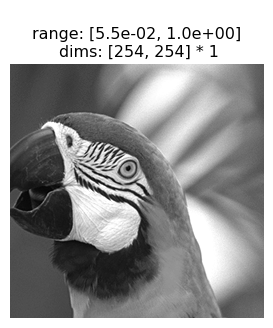

In [2]:
# crop the image to be square:
image_tensor = po.data.parrot().to(DEVICE).to(torch.float64)
image_tensor = po.tools.center_crop(image_tensor, min(image_tensor.shape[-2:]))

print("Torch image shape:", image_tensor.shape)

po.imshow(image_tensor);

Since the Front-end OnOff model only has two channel outputs, we can easily visualize the feature maps.
We'll apply a circular mask to this model's inputs to avoid edge artifacts in the synthesis.

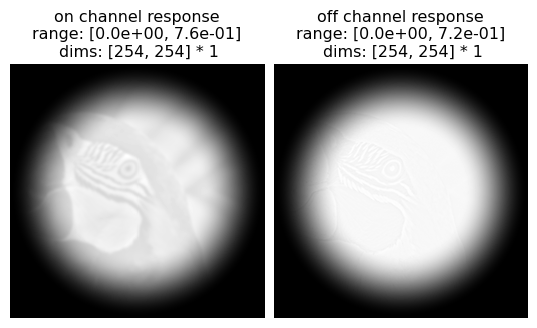

In [3]:
mdl_f = OnOff(kernel_size=(31, 31), pretrained=True, apply_mask=True, cache_filt=True)
po.tools.remove_grad(mdl_f)
mdl_f = mdl_f.to(DEVICE).to(image_tensor.dtype)
mdl_f.eval()

response_f = mdl_f(image_tensor)
po.imshow(
    response_f,
    title=["on channel response", "off channel response"],
);

## Synthesizing eigendistortions

### Front-end model: eigendistortion synthesis
Now that we have our Front End model set up, we can synthesize eigendistortions! This is done easily just by calling {func}`synthesis <plenoptic.synthesize.eigendistortion.Eigendistortion.synthesize>` after instantiating the {class}`Eigendistortion <plenoptic.synthesize.eigendistortion.Eigendistortion>` object. We'll synthesize the top and bottom `k`, representing the most- and least-noticeable eigendistortions for this model.

The paper synthesizes the top and bottom `k=1` eigendistortions, but we'll set `k>1` so the algorithm converges/stabilizes faster.

In [4]:
# synthesize the top and bottom k distortions
eigendist_f = Eigendistortion(image=image_tensor, model=mdl_f)
# this synthesis takes a long time to run, so we load in a cached version.
# see the following admonition for how to run this yourself
eigendist_f.load(
    fetch_data("berardino_onoff.pt"), tensor_equality_atol=1e-7, map_location=DEVICE
)

:::{admonition} How to run this synthesis manually
:class: dropdown note

```{code-block} python
:name: test_berardino_onoff
eigendist_f.synthesize(k=3, method="power", max_iter=2000)
```
:::


### Front-end model: eigendistortion display

Once synthesized, we can plot the distortion on the image using {func}`display_eigendistortion_all <plenoptic.synthesize.eigendistortion.display_eigendistortion_all>`. Feel free to adjust the constant `alpha` that scales the amount of each distortion on the image.

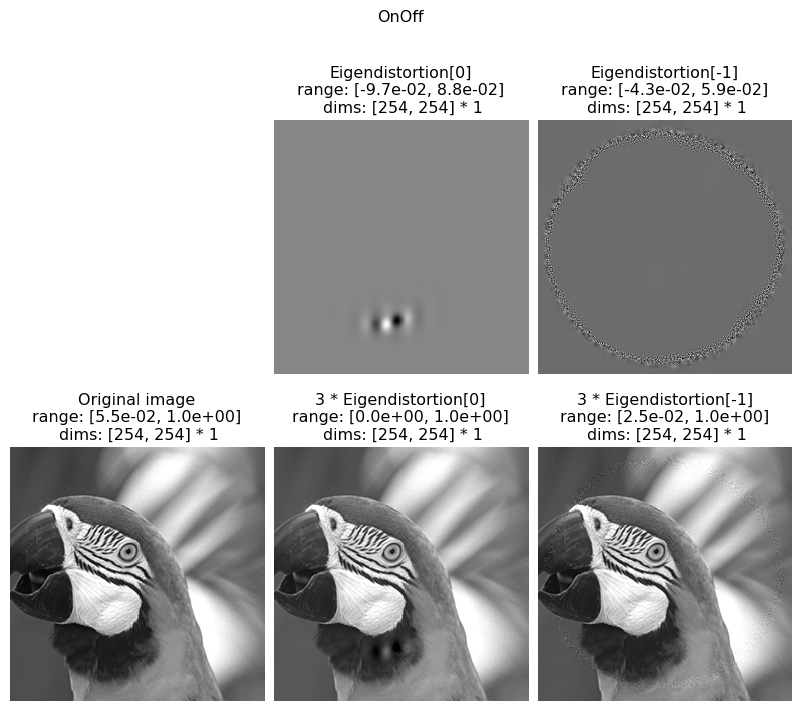

In [5]:
po.synth.eigendistortion.display_eigendistortion_all(
    eigendist_f,
    [0, -1],
    alpha=3,
    suptitle="OnOff",
);

### VGG16: eigendistortion synthesis

Following the lead of Berardino et al. (2017), let's compare the Front End model's eigendistortion to those of an early layer of VGG16! VGG16 takes as input color images, so we'll need to repeat the grayscale parrot along the RGB color dimension.

In [6]:
# Create a class that takes the nth layer output of a given model
class TorchVision(torch.nn.Module):
    def __init__(self, model, return_node: str):
        super().__init__()
        self.extractor = feature_extraction.create_feature_extractor(
            model, return_nodes=[return_node]
        )
        self.model = model
        self.return_node = return_node

    def forward(self, x):
        return self.extractor(x)[self.return_node]

VGG16 was trained on pre-processed ImageNet images with approximately zero mean and unit stdev, so we can preprocess our Parrot image the same way.

In [7]:
# VGG16
def normalize(img_tensor):
    """standardize the image for vgg16"""
    return (img_tensor - img_tensor.mean()) / img_tensor.std()


# store these for later so we can un-normalize the image for display purposes
orig_mean = image_tensor.mean().detach()
orig_std = image_tensor.std().detach()
image_tensor = normalize(image_tensor)

image_tensor3 = image_tensor.repeat(1, 3, 1, 1)

# "layer 3" according to Berardino et al (2017)
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1, progress=False)
mdl_v = TorchVision(vgg, "features.11").to(DEVICE).to(image_tensor.dtype)
po.tools.remove_grad(mdl_v)
mdl_v.eval()

eigendist_v = Eigendistortion(image=image_tensor3, model=mdl_v)
# this synthesis takes a long time to run, so we load in a cached version.
# see the following admonition for how to run this yourself
eigendist_v.load(
    fetch_data("berardino_vgg16.pt"), tensor_equality_atol=1e-7, map_location=DEVICE
)

:::{admonition} How to run this synthesis manually
:class: dropdown note

```{code-block} python
:name: test_berardino_vgg16
eigendist_v.synthesize(k=2, method="power", max_iter=5000)
```
:::

### VGG16: eigendistortion display

We can now display the most- and least-noticeable eigendistortions as before, then compare their quality to those of the Front-end model.

Since the distortions here were synthesized using a pre-processed (normalized) imagea, we can easily pass a function to unprocess the image.

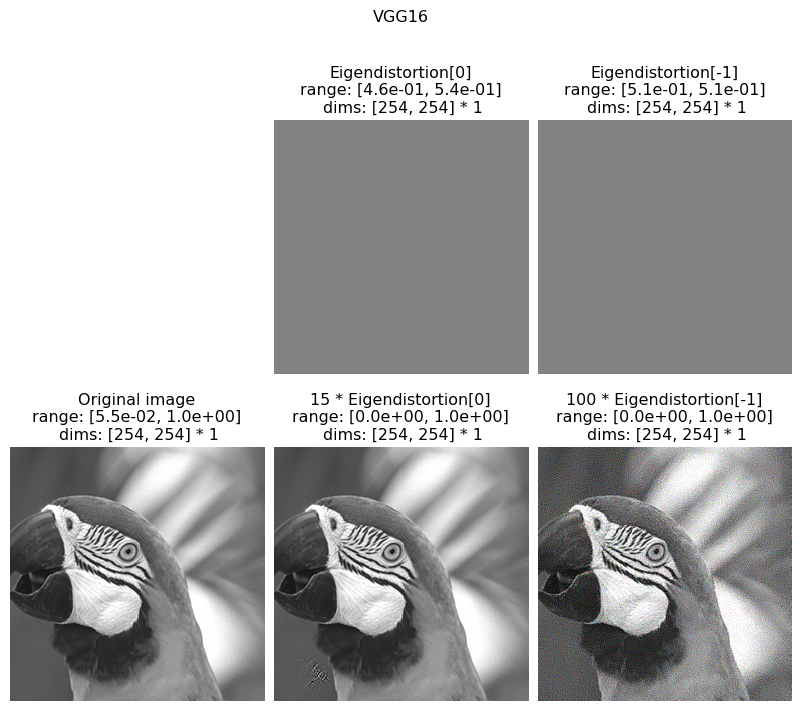

In [8]:
# create an image processing function to unnormalize the image and avg the channels to
# grayscale
def unnormalize(x):
    return x * orig_std.to(x.device) + orig_mean.to(x.device)


po.synth.eigendistortion.display_eigendistortion_all(
    eigendist_v,
    [0, -1],
    alpha=[15, 100],
    suptitle="VGG16",
    as_rgb=True,
    process_image=unnormalize,
);

## Final thoughts

To rigorously test which of these model's representations are more human-like, we'll have to conduct a perceptual experiment. For now, we'll just leave it to you to eyeball and decide which distortions are more or less noticeable!